## Entrenamiento

#### Importación de las librerías

In [53]:
import pyarrow.feather as feather
import importlib
import numpy as np
import matplotlib.pyplot as plt
import utils.train_utils as train_utils
import utils.plot_utils as plot_utils
from torchsummary import summary
import torch

import pickle 
from torch import nn

importlib.reload(train_utils)
importlib.reload(plot_utils)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from utils.train_utils import run_model, fit, timing
import torch.optim as optim
from torch.utils.data import Dataset
from utils.plot_utils import plot_roc_curve



#### Cargado de datos

In [6]:
X_train = feather.read_feather("./results/X_train.ftr")
X_test = feather.read_feather("./results/X_test.ftr")
y_train = feather.read_feather("./results/y_train.ftr").to_numpy().ravel()
y_test = feather.read_feather("./results/y_test.ftr").to_numpy().ravel()

### Adaboost

ROC_AUC = 0.9285620168587724

              precision    recall  f1-score   support

           0    0.94090   0.93193   0.93639     14573
           1    0.91405   0.92520   0.91959     11403

    accuracy                        0.92897     25976
   macro avg    0.92748   0.92856   0.92799     25976
weighted avg    0.92912   0.92897   0.92902     25976



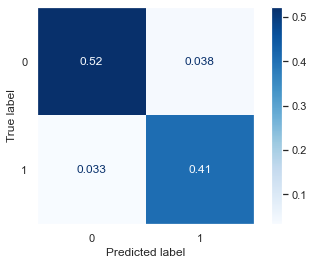

In [33]:
params_ad = {
    "n_estimators": 100,
    "random_state": 0,
}

model_ad = AdaBoostClassifier(**params_ad)
model_ad, roc_auc_ad = run_model(model_ad, X_train, y_train, X_test, y_test)


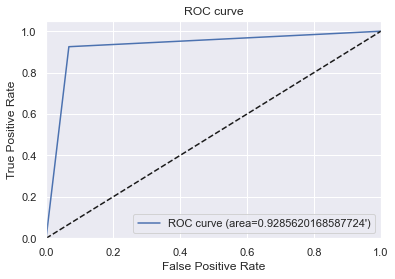

In [12]:
y_pred = model_ad.predict(X_test)
plot_roc_curve(y_test, y_pred)

### SVM

ROC_AUC = 0.9548056568894316

              precision    recall  f1-score   support

           0    0.96134   0.95890   0.96012     14573
           1    0.94764   0.95071   0.94917     11403

    accuracy                        0.95530     25976
   macro avg    0.95449   0.95481   0.95465     25976
weighted avg    0.95532   0.95530   0.95531     25976



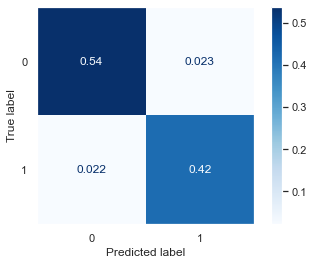

In [35]:
params_svm = {}

model_svm = SVC(**params_svm)
model_svm, roc_auc_svm = run_model(model_svm, X_train, y_train, X_test, y_test)

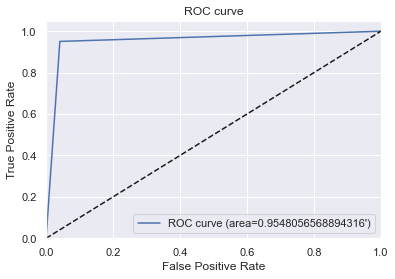

In [29]:
y_pred = model_svm.predict(X_test)
plot_roc_curve(y_test, y_pred)

### Decision tree

ROC_AUC = 0.9443018636171947

              precision    recall  f1-score   support

           0    0.95126   0.95087   0.95106     14573
           1    0.93724   0.93774   0.93749     11403

    accuracy                        0.94510     25976
   macro avg    0.94425   0.94430   0.94428     25976
weighted avg    0.94511   0.94510   0.94510     25976



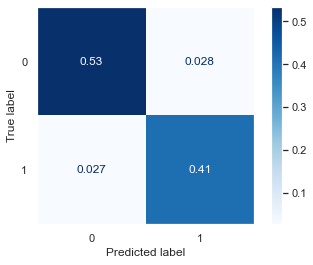

In [28]:
params_dt = {}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, roc_auc_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

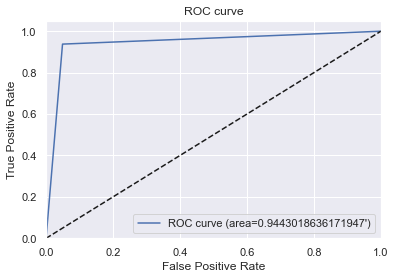

In [30]:
y_pred = model_dt.predict(X_test)
plot_roc_curve(y_test, y_pred)

### Random forest

ROC_AUC = 0.9615529341528721

              precision    recall  f1-score   support

           0    0.95890   0.97660   0.96767     14573
           1    0.96937   0.94651   0.95780     11403

    accuracy                        0.96339     25976
   macro avg    0.96414   0.96155   0.96274     25976
weighted avg    0.96350   0.96339   0.96334     25976



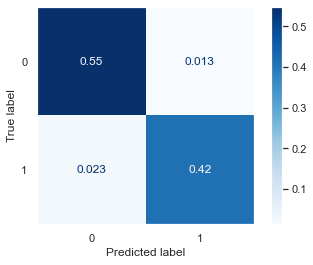

In [39]:
params_rf = {
    'max_depth': 25,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1200,
    'random_state': 42
}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

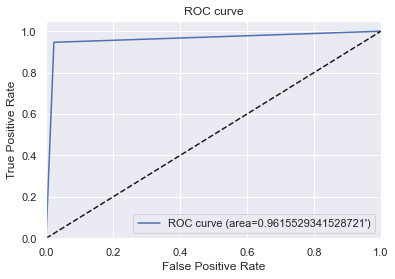

In [31]:
y_pred = model_rf.predict(X_test)
plot_roc_curve(y_test, y_pred)

### Logistic regression

ROC_AUC = 0.859699316601944

              precision    recall  f1-score   support

           0    0.89560   0.84533   0.86974     14573
           1    0.81556   0.87407   0.84380     11403

    accuracy                        0.85795     25976
   macro avg    0.85558   0.85970   0.85677     25976
weighted avg    0.86047   0.85795   0.85835     25976



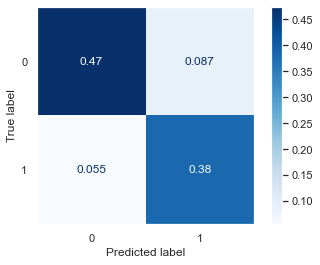

In [34]:
params_lr = {
    'random_state': 42
}

model_lr = LogisticRegression(**params_lr)
model_lr, roc_auc_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

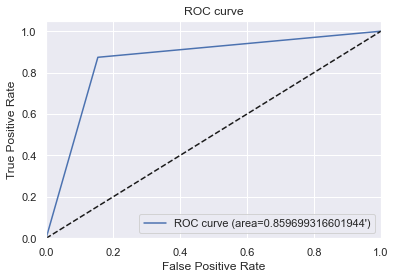

In [32]:
y_pred = model_lr.predict(X_test)
plot_roc_curve(y_test, y_pred)

### Neural network

In [36]:
# Se crea el modelo a entrenar
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer_1 = nn.Linear(19, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

model = Net()

In [37]:
# Se define el dataset
class CustomDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = torch.tensor(X.values).float()
    self.Y = torch.tensor(Y).float()

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.Y[idx]
    return x, y

In [38]:
# Se crean los dataloaders
params = {
    'batch_size': 64,
    'shuffle': True,
}

train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, **params)
test_loader = torch.utils.data.DataLoader(test_set, **params)

In [44]:
# Se entrena el modelo
dataloaders = {"train": train_loader, "val": test_loader,}
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,)

losses_train, losses_val = fit(model, criterion, optimizer, dataloaders, len(train_set), len(test_set), epochs=5)

cpu
[1] training loss: 0.11977, validation loss: 0.09938, train accuracy 94.91414642333984, val accuracy 95.8692626953125
[2] training loss: 0.10993, validation loss: 0.09953, train accuracy 95.2368392944336, val accuracy 95.89620971679688
[3] training loss: 0.10681, validation loss: 0.11024, train accuracy 95.41941833496094, val accuracy 95.030029296875
[4] training loss: 0.10494, validation loss: 0.09867, train accuracy 95.44659423828125, val accuracy 95.88081359863281
[5] training loss: 0.10134, validation loss: 0.09115, train accuracy 95.60709381103516, val accuracy 96.17723846435547


### Guardar modelos

In [48]:
model_dict = {"model_ad": model_ad, "model_rf": model_rf, "model_dt": model_dt, "model_lr": model_lr, "model_svm": model_svm, "model_nn": model}
for name, obj in model_dict.items():
    file_to_store = open(f"./results/models/{name}.pickle", "wb")
    pickle.dump(obj, file_to_store)